In [145]:
import gzip
import pandas as pd
import pandas_plink as pdpl
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import subprocess
from cyvcf2 import VCF
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# There are three file types for genetic data that interest us
# Multiple different samples of these files can be found on 1000 Genomes
# In the interest of size and reproducibility we will use just EUR.22 to showcase the method
# This method can be reproduced with any of the chromosomes included in the data folder
bim, fam, G = pdpl.read_plink("data/EUR.22.test/1000G.EUR.22")

# This file contains the gene expression data we will be using
gene_expr = pd.read_csv('data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', compression='gzip', sep='\t')

# We also want to grab the gene annotations
with gzip.open("data/gene_annot.txt.gz", "rt") as f:
    # Read the file content into a pandas DataFrame
    gene_annotations = pd.read_csv(f, sep="\t")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 18.80it/s]


In [4]:
# Combine the files so that we have users as rows, and their snps as columns
geno_df = pd.DataFrame(G.compute().transpose())
geno_df.columns = bim['snp']  # Use SNP IDs as columns
geno_df.index = fam['iid']  # Use individual IDs as rows

# Transpose gene expression data so that individual IDs are in the index as well
gene_expr_t = gene_expr.set_index('Gene_Symbol').transpose()

# The data isn't always consistent across all the files, so we want to only pull data we have all the information for
# Extract the individual IDs that match those in fam['iid']
gene_expr_t.index.name = 'iid'
matching_ids = gene_expr_t.index.intersection(fam['iid'])

# Filter both dataframes to only include these matching IDs
geno_df_filtered = geno_df.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(geno_df_filtered, gene_expr_filtered, test_size=0.25, random_state=1)

In [5]:
# Grab genes from desired chromosomes
chromosome = "22"
chr22_genes = gene_expr[gene_expr['Chr'] == chromosome]['Gene_Symbol']

# Initialize a list to store results for each SNP and gene as rows
chr22_results_list = []

for the_gene in chr22_genes:
    gene_info = gene_expr[gene_expr['Gene_Symbol'] == the_gene]
    snps_in_window = bim[(bim['chrom'] == chromosome) & 
                         (bim['pos'] >= int(gene_info['Coord'].iloc[0])-500000) & 
                         (bim['pos'] <= int(gene_info['Coord'].iloc[0])+500000)]
    
    # Get the SNP IDs from the filtered SNPs
    snp_ids = snps_in_window['snp'].values

    # Filter the genotype DataFrame for the SNPs in the window
    X_train_filtered = X_train.loc[:, snp_ids]

    # Filter the gene expression data for the gene of interest
    y_train_t = y_train.transpose()
    y_train_filtered = y_train_t.loc[the_gene]

    # Merge the gene expression data with genotype data
    merged_df = pd.concat([X_train_filtered, y_train_filtered], axis=1)

    # Rename the gene expression column for clarity
    merged_df.rename(columns={the_gene: 'gene_expression'}, inplace=True)
    
    # Ensure gene expression values are numeric
    y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

    for snp in X_train_filtered.columns:
        X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
        X = sm.add_constant(X)  # Add an intercept for the linear regression
    
        # Drop rows with missing or invalid data (NaN)
        valid_data = pd.concat([y, X], axis=1).dropna()
    
        # Run the regression only if valid data exists
        if len(valid_data) > 0:
            model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors

            if len(model.pvalues) > 1:
                # Append results for this SNP as a row in the results list
                chr22_results_list.append({
                    'Gene': the_gene,
                    'SNP': snp,
                    'p-value': model.pvalues.iloc[1],
                    'beta': model.params.iloc[1],
                    'r_squared': model.rsquared
                })
            else:
                print(f"Insufficient model output for SNP {snp}, skipping.")

# Convert the list of results into a DataFrame
chr22_results_df = pd.DataFrame(chr22_results_list)

Insufficient model output for SNP rs17001322, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs138168, skipping.
Insufficient model output for SNP rs138171, skipping.
Insufficient model output for SNP rs138168, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs5999980, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs17001322, skipping.
Insufficient model output for SNP rs5999980, skipping.
Insufficient model output for SNP rs8142085, skipping.
Insufficient model output for SNP rs17001322, skipping.
Insufficient model output for SNP rs5999980, skipping.
Insufficient model output for SNP rs138168, skipping.
Insufficient model output for SNP rs138171, skipping.
Insufficient

In [54]:
chr22_results_df.to_csv('chr22_eqtl_data.txt', sep='\t', index=False)

In [19]:
X_train

snp,rs9617528,rs4911642,rs7287144,rs5748662,rs5994034,rs4010554,rs4010558,rs3954571,rs11089179,rs9604821,...,rs8137951,rs2301584,rs756638,rs3810648,rs2285395,rs13056621,rs3865766,rs3888396,rs2238837,rs28729663
iid,,,,,,,,,,,,,,,,,,,,,
NA11832,1.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,2.0
HG00096,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
NA12842,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,1.0,0.0,2.0,0.0,0.0
NA11831,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,...,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
HG00189,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA12006,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
NA12890,0.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
HG00243,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,2.0


In [25]:
ciseQTL_under_05 = sum(chr22_results_df['p-value'] < (0.05))
sig_ciseQTL = sum(chr22_results_df['p-value'] < (0.05/(gene_expr[gene_expr['Chr'] == chromosome].shape[0]*X_train.shape[1])))

print("eQTL's crossing 0.05 p-value cutoff: " + str(ciseQTL_under_05))
print("Significant eQTL's (0.05/Number of SNP-gene pairs tested): " + str(sig_ciseQTL))

chr22_ciseQTL_under_05 = chr22_results_df[chr22_results_df['p-value'] < (0.05)]
chr22_ciseQTL_under_05.to_csv('chr22_eQTL_under_05.txt', sep='\t', index=False)

eQTL's crossing 0.05 p-value cutoff: 21119
Significant eQTL's (0.05/Number of SNP-gene pairs tested): 640


In [71]:
# Randomly select a Gene to perform PRS for:

gene_PRS = chr22_results_df[chr22_results_df['Gene'] == 'ENSG00000185065.6']

gene_coord = gene_expr[gene_expr['Gene_Symbol'] == 'ENSG00000185065.6']['Coord']
snps_in_window = bim[(bim['chrom'] == '22') & 
                         (bim['pos'] >= int(gene_coord.iloc[0])-500000) & 
                         (bim['pos'] <= int(gene_coord.iloc[0])+500000)]

gene_PRS_copy = gene_PRS.copy()
gene_PRS_copy['neg_log10_p'] = -np.log10(gene_PRS['p-value'])
gene_PRS_copy = pd.merge(gene_PRS_copy, snps_in_window, left_on='SNP', right_on='snp')
gene_PRS_copy

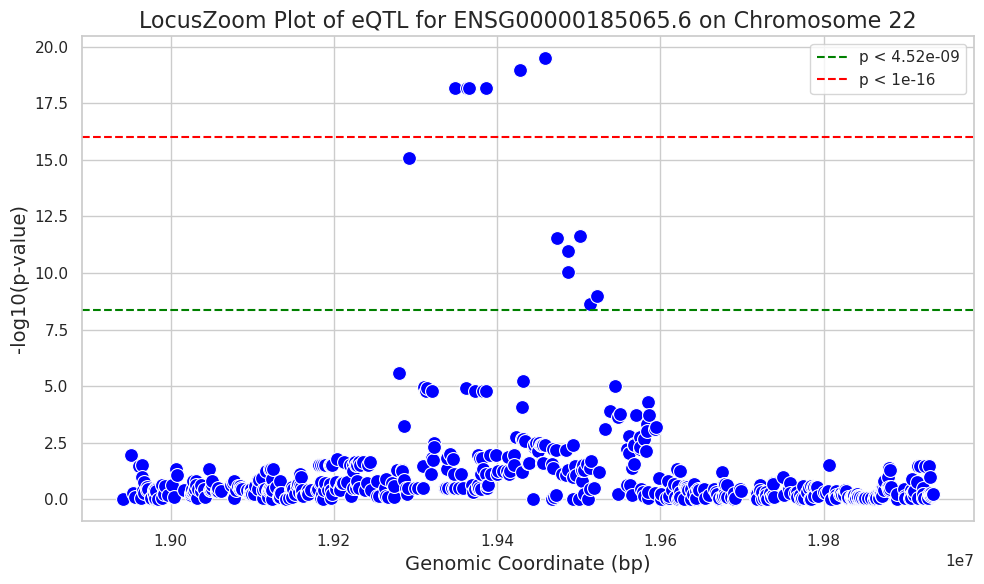

In [144]:
# Create a locus zoom plot to look at results
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=gene_PRS_copy, x='pos', y='neg_log10_p', color='blue', s=100)

# Adding labels and title
plt.title('LocusZoom Plot of eQTL for ENSG00000185065.6 on Chromosome 22', fontsize=16)
plt.xlabel('Genomic Coordinate (bp)', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=14)

# Adding a horizontal line for significance threshold (e.g., p < 0.05)
significance_threshold = -np.log10(0.05/(gene_expr[gene_expr['Chr'] == chromosome].shape[0]*X_train.shape[1]))
plt.axhline(y=significance_threshold, color='green', linestyle='--', label='p < 4.52e-09')
plt.axhline(y=-np.log10(1/(10**16)), color='red', linestyle='--', label='p < 1e-16')

# Customize x-axis limits (optional)
plt.xlim([gene_PRS_copy['pos'].min() - 50000, gene_PRS_copy['pos'].max() + 50000])

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [131]:
gene_PRS_copy

,Gene,SNP,p-value,beta,r_squared,neg_log10_p,chrom,snp,cm,pos,a0,a1,i
0,ENSG00000185065.6,rs9605907,0.937316,0.000892,0.000024,0.028114,22,rs9605907,9.260938,18941457,A,G,895
1,ENSG00000185065.6,rs5993445,0.011614,-0.027730,0.024619,1.935016,22,rs5993445,9.268334,18951545,C,T,896
2,ENSG00000185065.6,rs2540627,0.542968,-0.006235,0.001447,0.265226,22,rs2540627,9.270369,18954629,A,G,897
3,ENSG00000185065.6,rs2077200,0.786703,-0.002750,0.000287,0.104189,22,rs2077200,9.272427,18956203,A,G,898
4,ENSG00000185065.6,rs7288481,0.033584,-0.022620,0.017519,1.473871,22,rs7288481,9.279687,18961782,A,G,899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,ENSG00000185065.6,rs933271,0.522089,0.006539,0.001602,0.282256,22,rs933271,11.102842,19931407,C,T,1461
567,ENSG00000185065.6,rs1544325,0.748081,-0.003000,0.000404,0.126051,22,rs1544325,11.103098,19931668,A,G,1462
568,ENSG00000185065.6,rs8185002,0.682046,-0.004212,0.000657,0.166186,22,rs8185002,11.104430,19933048,G,T,1463
569,ENSG00000185065.6,rs174674,0.564321,0.005839,0.001300,0.248474,22,rs174674,11.105374,19934025,A,G,1464


In [132]:
p_value_thresholds = [1.0/(10**i) for i in np.arange(0,19)]
results = []

for threshold in p_value_thresholds:
    # Step 1: Filter SNPs based on p-value threshold
    filtered_snps = gene_PRS_copy[gene_PRS_copy['p-value'] <= threshold]
    
    # Step 2: Match SNPs with X_train
    snp_intersection = set(filtered_snps['snp']).intersection(X_train.columns)
    X_filtered = X_train[list(snp_intersection)]
    
    # Step 3: Multiply genotypes by beta values
    beta_values = filtered_snps.set_index('snp').loc[list(snp_intersection), 'beta']
    predicted_expression = np.dot(X_filtered.values, beta_values.values)
    
    # Step 4: Compare with actual expression
    actual_expression = y_train['ENSG00000185065.6']
    r2 = r2_score(actual_expression, predicted_expression)
    
    # Save results
    results.append({'p_value_threshold': threshold, 'r2_score': r2})

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)


In [138]:
print('ENSG00000185065.6 Thresholding Results')
print("")
best_threshold = results_df.loc[results_df['r2_score'].idxmax()]
print(f"Best p-value threshold: {best_threshold['p_value_threshold']}")
print("")
print(results_df)

ENSG00000185065.6 Thresholding Results

Best p-value threshold: 1e-16

    p_value_threshold    r2_score
0        1.000000e+00 -839.447577
1        1.000000e-01 -259.257622
2        1.000000e-02 -734.888324
3        1.000000e-03 -725.377420
4        1.000000e-04 -557.496951
5        1.000000e-05 -356.843576
6        1.000000e-06 -266.321619
7        1.000000e-07 -266.321619
8        1.000000e-08 -266.321619
9        1.000000e-09 -186.755947
10       1.000000e-10 -186.755947
11       1.000000e-11 -119.654019
12       1.000000e-12  -64.796741
13       1.000000e-13  -64.796741
14       1.000000e-14  -64.796741
15       1.000000e-15  -64.796741
16       1.000000e-16  -43.495337
17       1.000000e-17  -43.495337
18       1.000000e-18  -43.495337


In [141]:
p_value_thresholds = [1.0 / (10**i) for i in np.arange(0, 19)]
results = []

for threshold in p_value_thresholds:
    # Step 1: Filter SNPs based on p-value threshold
    filtered_snps = selected_snps[selected_snps['p-value'] <= threshold]
    
    # Step 2: Match SNPs with X_train and X_test
    snp_intersection = set(filtered_snps['snp']).intersection(X_train.columns)
    if not snp_intersection:  # Skip if no SNPs pass the threshold
        results.append({'p_value_threshold': threshold, 'train_r2_score': np.nan, 'test_r2_score': np.nan})
        continue
    X_train_filtered = X_train[list(snp_intersection)]
    X_test_filtered = X_test[list(snp_intersection)]
    
    # Step 3: Multiply genotypes by beta values
    beta_values = filtered_snps.set_index('snp').loc[list(snp_intersection), 'beta']
    predicted_train_expression = np.dot(X_train_filtered.values, beta_values.values)
    predicted_test_expression = np.dot(X_test_filtered.values, beta_values.values)
    
    # Step 4: Compare with actual expression
    actual_train_expression = y_train['ENSG00000185065.6']
    actual_test_expression = y_test['ENSG00000185065.6']
    train_r2 = r2_score(actual_train_expression, predicted_train_expression)
    test_r2 = r2_score(actual_test_expression, predicted_test_expression)
    
    # Save results
    results.append({
        'p_value_threshold': threshold,
        'train_r2_score': train_r2,
        'test_r2_score': test_r2
    })

# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Identify the best threshold for train and test
best_train_threshold = results_df.loc[results_df['train_r2_score'].idxmax()]
best_test_threshold = results_df.loc[results_df['test_r2_score'].idxmax()]
print('ENSG00000185065.6 PRS Thresholding Results')
print("")
print(f"Best p-value threshold (Train): {best_train_threshold['p_value_threshold']}")
print(f"Best p-value threshold (Test): {best_test_threshold['p_value_threshold']}")
print("")
print(results_df)

ENSG00000185065.6 PRS Thresholding Results

Best p-value threshold (Train): 1e-16
Best p-value threshold (Test): 1e-16

    p_value_threshold  train_r2_score  test_r2_score
0        1.000000e+00     -839.447577    -993.540732
1        1.000000e-01     -259.257622    -301.514380
2        1.000000e-02     -734.888324    -790.104239
3        1.000000e-03     -725.377420    -815.244050
4        1.000000e-04     -557.496951    -630.971652
5        1.000000e-05     -356.843576    -406.586696
6        1.000000e-06     -266.321619    -303.981696
7        1.000000e-07     -266.321619    -303.981696
8        1.000000e-08     -266.321619    -303.981696
9        1.000000e-09     -186.755947    -212.711019
10       1.000000e-10     -186.755947    -212.711019
11       1.000000e-11     -119.654019    -138.378498
12       1.000000e-12      -64.796741     -75.501855
13       1.000000e-13      -64.796741     -75.501855
14       1.000000e-14      -64.796741     -75.501855
15       1.000000e-15      -64.7

In [153]:
# Step 1: Read the VCF file
vcf_file = "./data/genome_Tiffany_AmariutaBartell.vcf"
vcf = VCF(vcf_file)

In [154]:
# Step 2: Extract genotypes for relevant SNPs
individual_genotypes = {}
for record in vcf:
    if record.ID in selected_snps['snp'].values:  # Match SNPs
        genotypes = record.genotypes[0][:3]  # Genotype for the first individual
        individual_genotypes[record.ID] = sum(genotypes)  # Sum 0, 1, 2

In [156]:
# Step 3: Calculate PRS
filtered_snps = selected_snps[selected_snps['p-value'] <= 1.0/(10**16)]

In [165]:
filtered_snps

,Gene,SNP,p-value,beta,r_squared,neg_log10_p,chrom,snp,cm,pos,a0,a1,i
234,ENSG00000185065.6,rs737810,6.414605e-19,0.096066,0.265769,18.192830,22,rs737810,9.848782,19348199,A,G,1129
240,ENSG00000185065.6,rs2073773,6.414605e-19,0.096066,0.265769,18.192830,22,rs2073773,9.853085,19362618,T,G,1135
241,ENSG00000185065.6,rs2285334,6.414605e-19,0.096066,0.265769,18.192830,22,rs2285334,9.853086,19365286,C,T,1136
258,ENSG00000185065.6,rs2238768,6.414605e-19,0.096066,0.265769,18.192830,22,rs2238768,9.853095,19386633,C,T,1153
276,ENSG00000185065.6,rs11744,1.026117e-19,0.096727,0.276103,18.988803,22,rs11744,9.856112,19428511,G,A,1171
298,ENSG00000185065.6,rs17811336,3.230245e-20,0.098882,0.282547,19.490765,22,rs17811336,9.859676,19458412,G,A,1193


In [161]:
X_train[filtered_snps['SNP']]

snp,rs737810,rs2073773,rs2285334,rs2238768,rs11744,rs17811336
iid,,,,,,
NA11832,2.0,2.0,2.0,2.0,2.0,2.0
HG00096,1.0,1.0,1.0,1.0,1.0,1.0
NA12842,1.0,1.0,1.0,1.0,1.0,1.0
NA11831,2.0,2.0,2.0,2.0,2.0,2.0
HG00189,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
NA12006,1.0,1.0,1.0,1.0,1.0,1.0
NA12890,1.0,1.0,1.0,1.0,1.0,1.0
HG00243,2.0,2.0,2.0,2.0,2.0,2.0


In [168]:
[sum() ]np.dot(X_train[filtered_snps['SNP']], filtered_snps['beta'])

array([1.15974526, 0.57987263, 0.57987263, 1.15974526, 0.57987263,
       0.57987263, 1.15974526, 1.15974526, 0.57987263, 1.15974526,
       0.57987263, 1.15974526, 1.15974526, 1.15974526, 0.57987263,
       1.15974526, 1.15974526, 1.15974526, 0.57987263, 1.15974526,
       1.15974526, 1.15974526, 1.15974526, 0.57987263, 1.15974526,
       1.15974526, 0.57987263, 1.15974526, 1.15974526, 0.57987263,
       1.15974526, 1.15974526, 1.15974526, 0.57987263, 1.15974526,
       0.57987263, 0.57987263, 0.        , 1.15974526, 0.57987263,
       1.15974526, 0.57987263, 1.15974526, 1.15974526, 0.57987263,
       0.        , 1.15974526, 1.06301811, 0.57987263, 1.15974526,
       0.        , 1.15974526, 1.15974526, 0.96413626, 1.15974526,
       1.15974526, 1.15974526, 0.57987263, 1.15974526, 1.15974526,
       1.15974526, 0.57987263, 1.06301811, 1.15974526, 0.57987263,
       1.15974526, 0.57987263, 0.57987263, 1.15974526, 0.57987263,
       0.57987263, 0.        , 0.57987263, 1.15974526, 1.15974

Train R^2 Score: -43.49533672253008
Test R^2 Score: -50.49246510041541
VCF Individual PRS Score: 0.09606590857160988


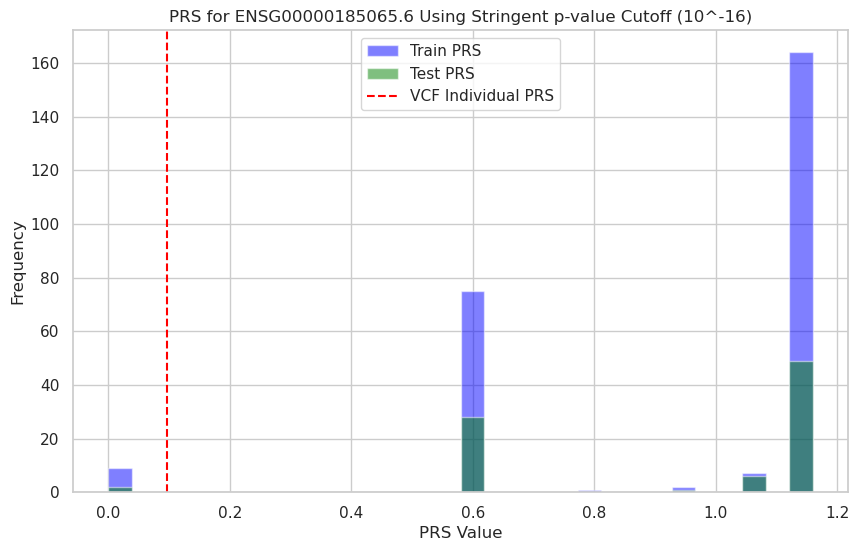

In [173]:
# Define the p-value threshold
threshold = 1.0 / (10**16)

# Step 1: Filter SNPs based on p-value threshold
filtered_snps = selected_snps[selected_snps['p-value'] <= threshold]

# Step 2: Match SNPs with X_train and X_test
snp_intersection = set(filtered_snps['snp']).intersection(X_train.columns)
if not snp_intersection:
    print("No SNPs passed the threshold.")
else:
    # Step 3: Filter the data
    X_train_filtered = X_train[list(snp_intersection)]
    X_test_filtered = X_test[list(snp_intersection)]
    
    # Step 4: Multiply genotypes by beta values to get the PRS scores
    beta_values = filtered_snps.set_index('snp').loc[list(snp_intersection), 'beta']
    
    # Predicted expression values for train and test
    predicted_train_expression = np.dot(X_train_filtered.values, beta_values.values)
    predicted_test_expression = np.dot(X_test_filtered.values, beta_values.values)
    
    # Step 5: Actual expression values from y_train and y_test
    actual_train_expression = y_train['ENSG00000185065.6']
    actual_test_expression = y_test['ENSG00000185065.6']
    
    # Step 6: Calculate R2 scores for train and test
    train_r2 = r2_score(actual_train_expression, predicted_train_expression)
    test_r2 = r2_score(actual_test_expression, predicted_test_expression)
    
    # Step 7: Calculate the PRS score for the VCF individual using individual_genotypes
    vcf_predicted_expression = 0
    for snp, genotype in individual_genotypes.items():
        if snp in snp_intersection:  # Check if SNP is relevant (present in the intersection)
            beta_value = beta_values[snp]
            vcf_predicted_expression += genotype * beta_value
    
    # Print out the PRS for the train, test, and VCF individual    
    print("Train R^2 Score:", train_r2)
    print("Test R^2 Score:", test_r2)
    print("VCF Individual PRS Score:", vcf_predicted_expression)

    # Step 8: Plot the PRS distribution for train and test
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_train_expression, bins=30, alpha=0.5, label='Train PRS', color='blue')
    plt.hist(predicted_test_expression, bins=30, alpha=0.5, label='Test PRS', color='green')
    plt.axvline(vcf_predicted_expression, color='red', linestyle='dashed', label="VCF Individual PRS")
    plt.title("PRS for ENSG00000185065.6 Using Stringent p-value Cutoff (10^-16)")
    plt.xlabel("PRS Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

Train R^2 Score: -356.84357567045134
Test R^2 Score: -406.5866956002781
VCF Individual PRS Score: 0.09606590857160988


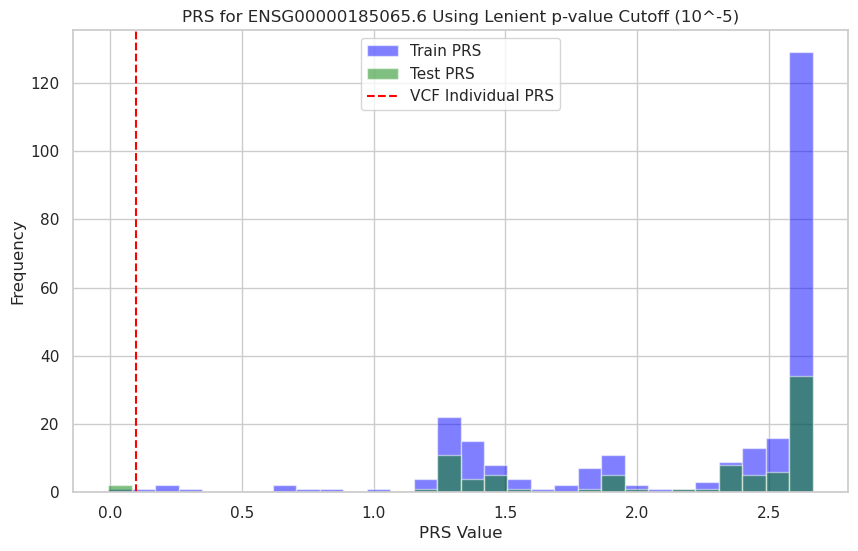

In [177]:
# Define the p-value threshold
threshold = 1.0 / (10**5)

# Step 1: Filter SNPs based on p-value threshold
filtered_snps = selected_snps[selected_snps['p-value'] <= threshold]

# Step 2: Match SNPs with X_train and X_test
snp_intersection = set(filtered_snps['snp']).intersection(X_train.columns)
if not snp_intersection:
    print("No SNPs passed the threshold.")
else:
    # Step 3: Filter the data
    X_train_filtered = X_train[list(snp_intersection)]
    X_test_filtered = X_test[list(snp_intersection)]
    
    # Step 4: Multiply genotypes by beta values to get the PRS scores
    beta_values = filtered_snps.set_index('snp').loc[list(snp_intersection), 'beta']
    
    # Predicted expression values for train and test
    predicted_train_expression = np.dot(X_train_filtered.values, beta_values.values)
    predicted_test_expression = np.dot(X_test_filtered.values, beta_values.values)
    
    # Step 5: Actual expression values from y_train and y_test
    actual_train_expression = y_train['ENSG00000185065.6']
    actual_test_expression = y_test['ENSG00000185065.6']
    
    # Step 6: Calculate R2 scores for train and test
    train_r2 = r2_score(actual_train_expression, predicted_train_expression)
    test_r2 = r2_score(actual_test_expression, predicted_test_expression)
    
    # Step 7: Calculate the PRS score for the VCF individual using individual_genotypes
    vcf_predicted_expression = 0
    for snp, genotype in individual_genotypes.items():
        if snp in snp_intersection:  # Check if SNP is relevant (present in the intersection)
            beta_value = beta_values[snp]
            vcf_predicted_expression += genotype * beta_value
    
    # Print out the PRS for the train, test, and VCF individual    
    print("Train R^2 Score:", train_r2)
    print("Test R^2 Score:", test_r2)
    print("VCF Individual PRS Score:", vcf_predicted_expression)

    # Step 8: Plot the PRS distribution for train and test
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_train_expression, bins=30, alpha=0.5, label='Train PRS', color='blue')
    plt.hist(predicted_test_expression, bins=30, alpha=0.5, label='Test PRS', color='green')
    plt.axvline(vcf_predicted_expression, color='red', linestyle='dashed', label="VCF Individual PRS")
    plt.title("PRS for ENSG00000185065.6 Using Lenient p-value Cutoff (10^-5)")
    plt.xlabel("PRS Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()